In [1]:
! git clone https://github.com/ranveersingh81/scanpath.git

Cloning into 'scanpath'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 7), reused 23 (delta 4), pack-reused 0
Receiving objects: 100% (26/26), 1.29 MiB | 4.37 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import pandas as pd
import os
# import scanpath as scp
import math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import pickle


In [3]:
def get_file_data(file):
    file_path = os.path.join('./data/scanpaths/', file)
    df = pd.read_csv(file_path, delimiter='\t')
    cols = df.columns.to_list()
    df['file'] = file.replace("_scanpath.tsv", "")
    df = df[['file'] + cols]
    return df

In [ ]:
files = [i for i in os.listdir('./data/scanpaths/')]
master_df = get_file_data(files[0])

for i  in  files[1:]:
    master_df = pd.concat([master_df, get_file_data(i)])

reader_data = pd.read_csv("/Users/RSingh81/Documents/personal_projects/scanpath/data/reader_meta_mean_and_per-text.csv")

In [ ]:
all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line',
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

In [ ]:
def get_scanpath(scan_record):
    scanpath = master_df[master_df['file'] == scan_record]
    scanpath = scanpath[['fixation_index', 'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'line', 'char_index_in_line',
                    'fixation_position_x', 'fixation_position_y', 'word_index_in_text', 'sent_index_in_text', 'char_index_in_text']]
    scanpath['change_in_word_flag'] = (scanpath['word_index_in_text'].diff() == 0).astype(int).shift(-1)
    scanpath['change_in_word'] = (scanpath['change_in_word_flag'] == 0).cumsum().shift(1).fillna(0)
    scanpath['same_word_next_saccade_duration'] = scanpath['change_in_word_flag']*scanpath['next_saccade_duration']
    scanpath['next_saccade_duration'] = scanpath['next_saccade_duration'] - scanpath['same_word_next_saccade_duration']
    scanpath['fixation_duration'] = scanpath['same_word_next_saccade_duration'] + scanpath['fixation_duration']
    scanpath = scanpath.drop('same_word_next_saccade_duration', axis =1)
    scanpath = scanpath.groupby(['change_in_word', 'word_index_in_text']).aggregate({'fixation_duration':'sum', 'next_saccade_duration':'sum', 'fixation_position_x':'mean', 'fixation_position_y':'mean'}).reset_index()
    scanpath['cum_fixation_duration'] = scanpath['fixation_duration'].cumsum().shift(1).fillna(0)
    scanpath = scanpath.reset_index()
    return scanpath

In [ ]:
all_columns = ['file', 'fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3',
'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'roi', 'char_index_in_line',
'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'fixation_position_x', 'fixation_position_y',
'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric']

In [ ]:
with open('output.pickle', 'rb') as handle:
    analysis = pickle.load(handle)

EOFError: Ran out of input

reader85_p0 reader23_p0
(368, 257)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


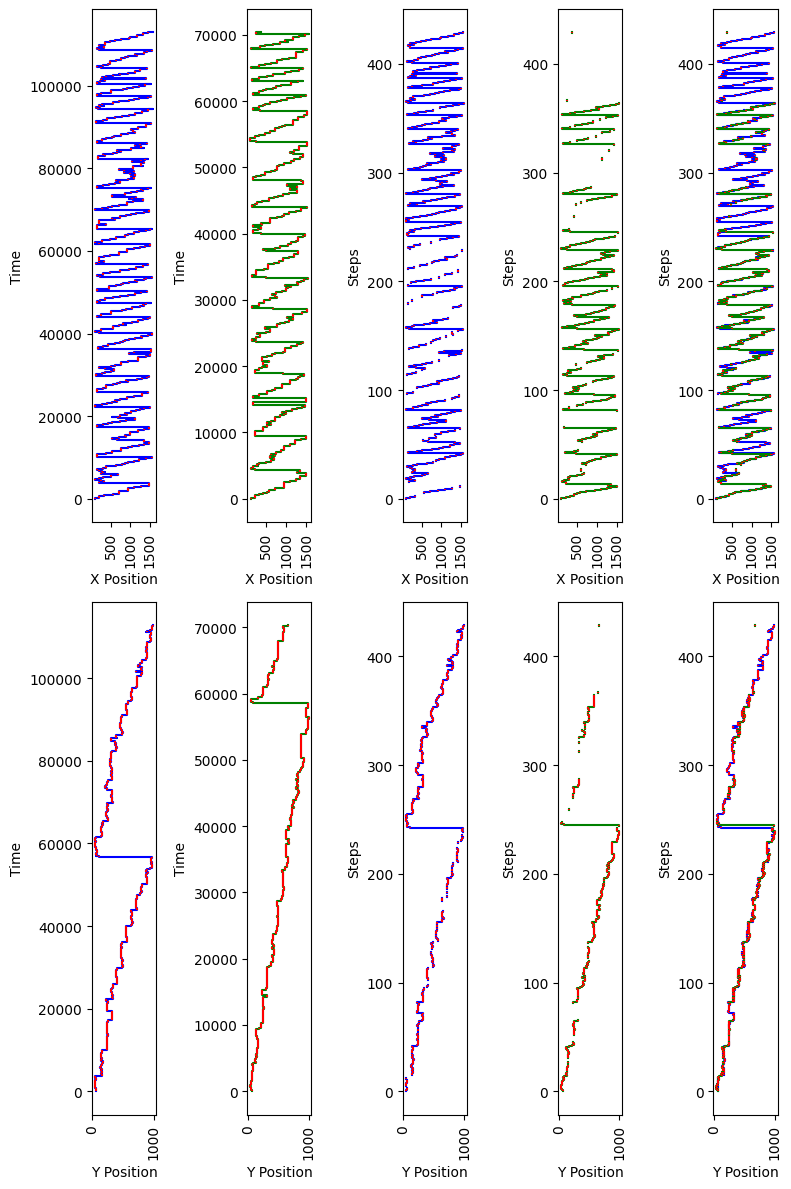

reader23_p0 reader1_p0
(257, 265)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


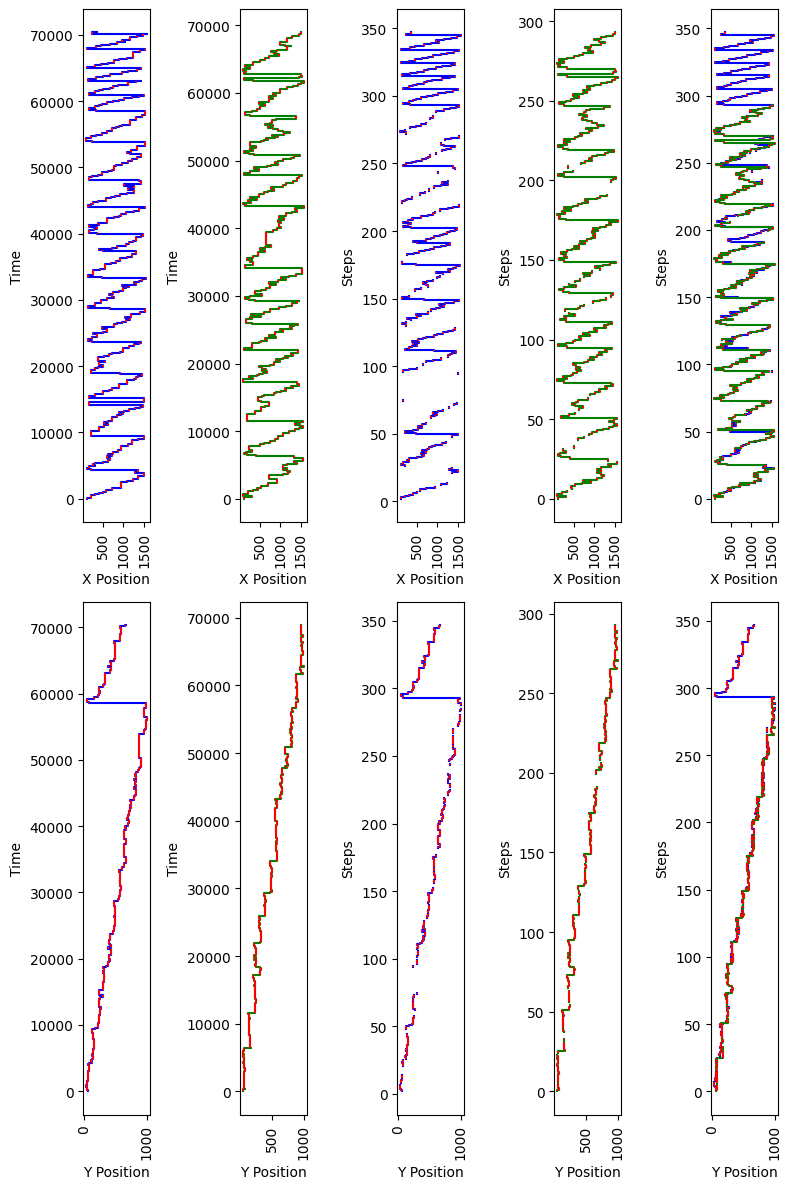

reader1_p0 reader64_p0
(265, 265)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


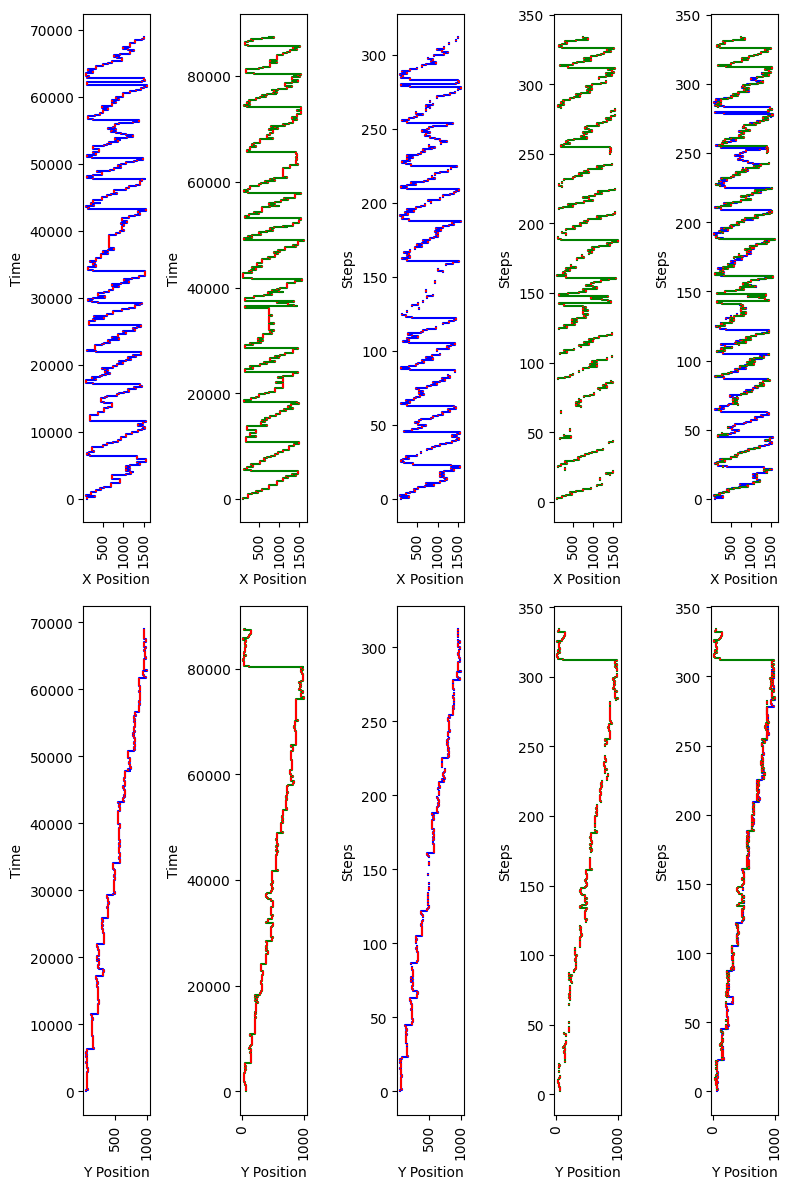

reader64_p0 reader40_p0
(265, 440)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


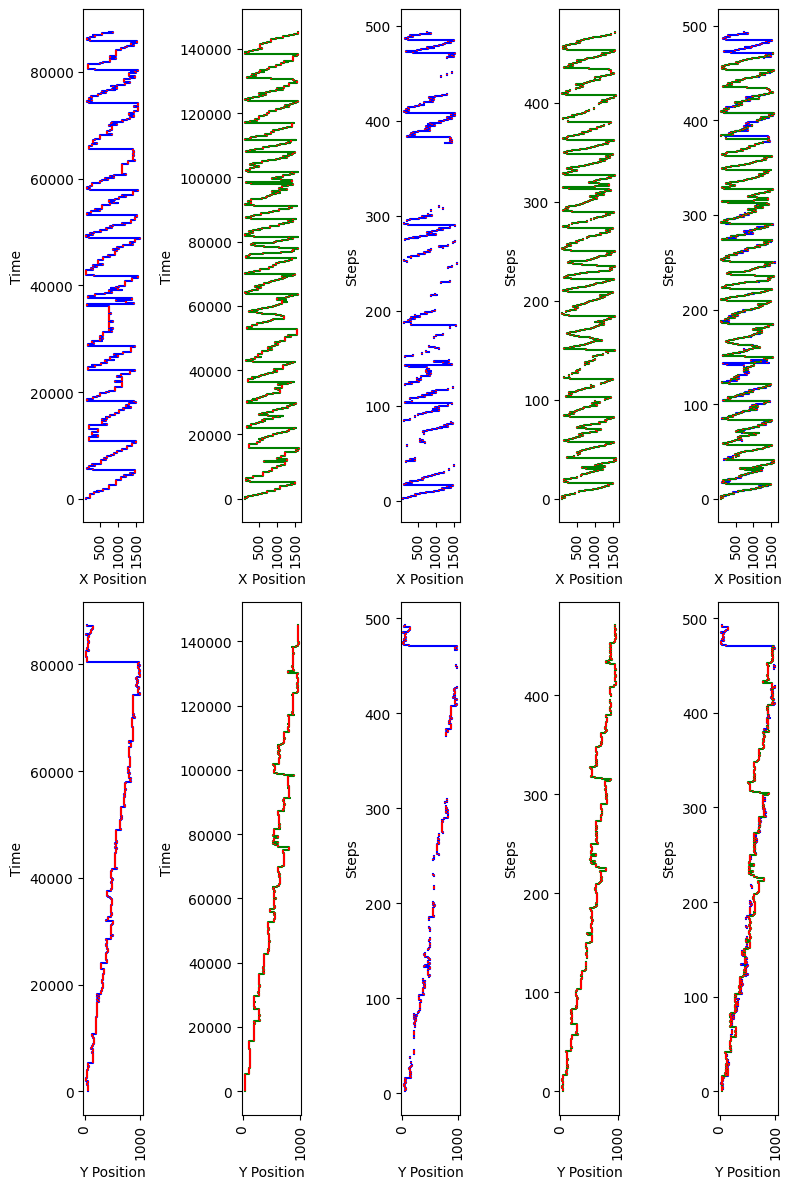

reader40_p0 reader72_p0
(440, 333)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


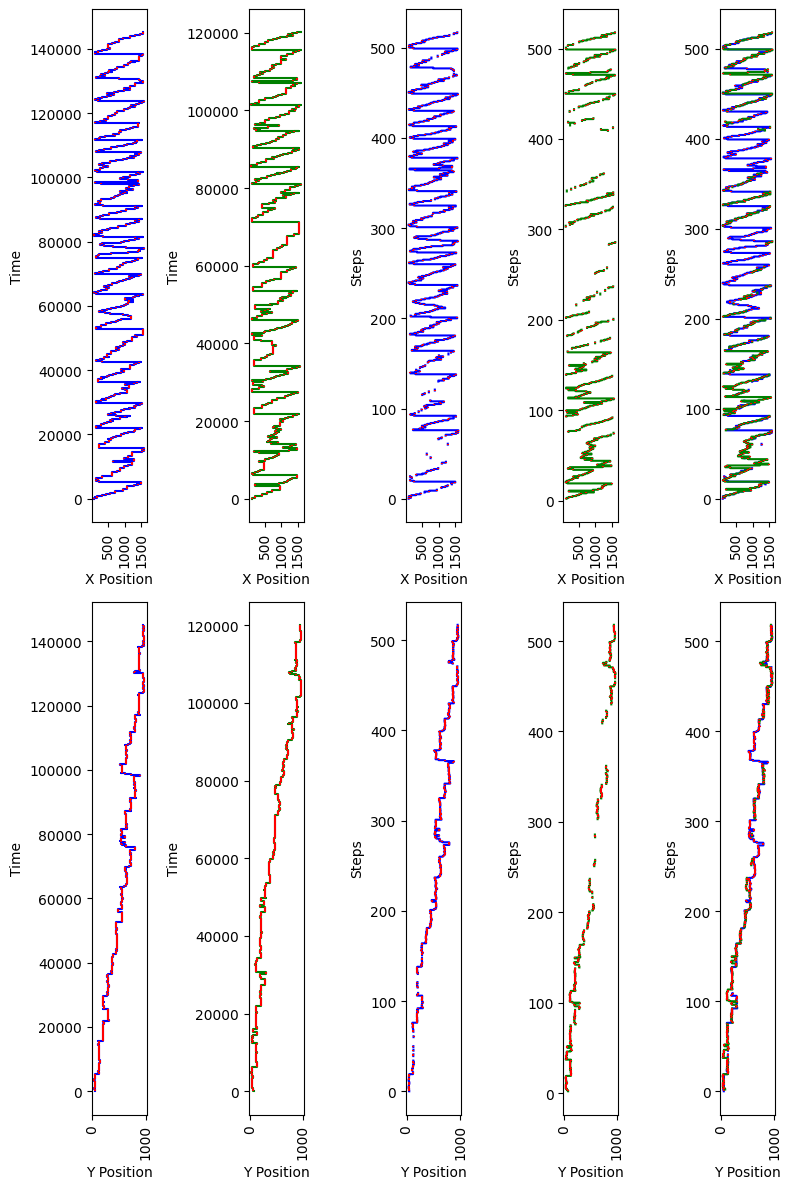

reader72_p0 reader35_p0
(333, 241)


/Users/RSingh81/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


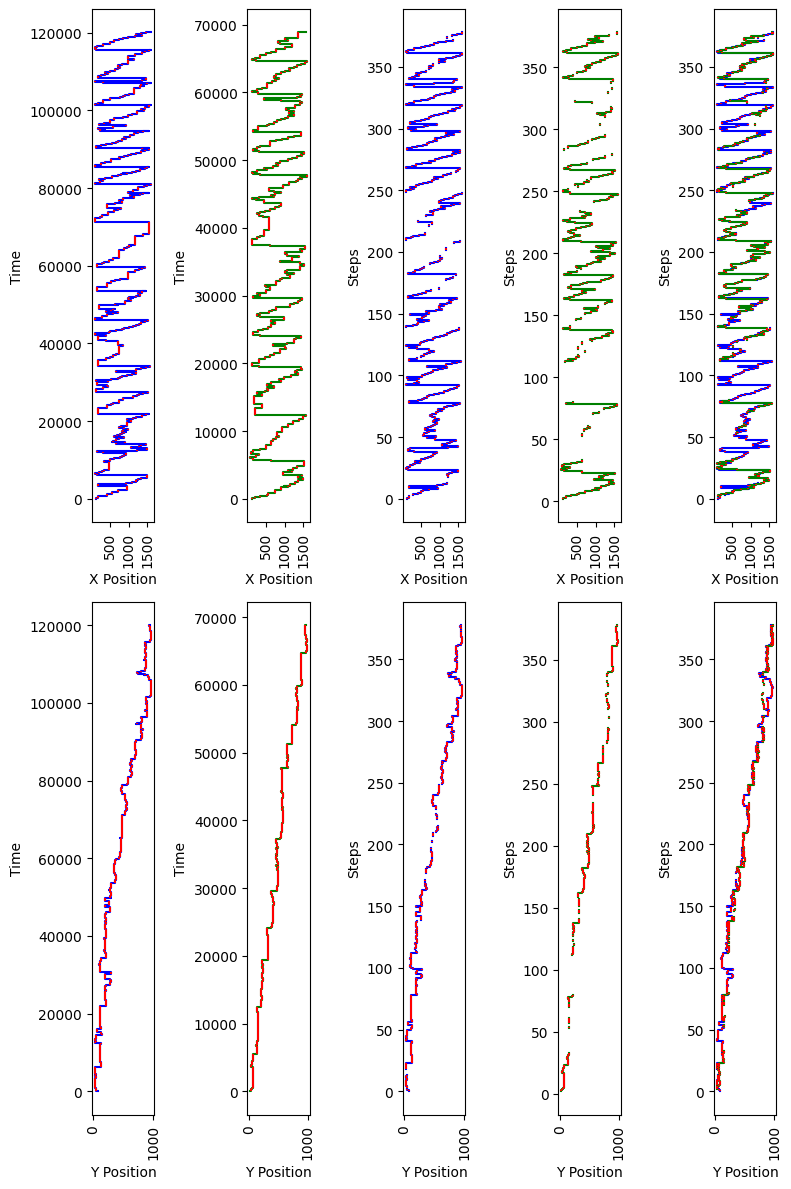

KeyboardInterrupt: 

In [ ]:
# center_x = 840
# center_y = 525
# distance = 61
# unit = 0.0282

# files = master_df['file'].unique()
# files = [i for i in files if 'p0' in i]

# for i in range(len(files)-1):
#     scanpath1 = get_scanpath(files[i])
#     scanpath2 = get_scanpath(files[i+1])
#     print(files[i], files[i+1])
#     score, path, alignment, path_df  = rscasim(scanpath1, scanpath2, center_x, center_y, distance, unit, modulator=0.83)
#     # alignment = alignment.drop(0, axis=0).reset_index(drop=True)
#     alignment = alignment.merge(scanpath1[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='s', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_s', 'fixation_position_y':'fixation_position_y_s',                                                                                                                                                                                         'fixation_duration':'fixation_duration_s', 'cum_fixation_duration':'cum_fixation_duration_s'}).drop('index', axis=1)
#     alignment = alignment.merge(scanpath2[['index', 'fixation_position_x', 'fixation_position_y', 'fixation_duration', 'cum_fixation_duration']], left_on='t', right_on='index', how='left').rename(columns={'fixation_position_x':'fixation_position_x_t', 'fixation_position_y':'fixation_position_y_t',
#                                                                                                                                                                                                             'fixation_duration':'fixation_duration_t', 'cum_fixation_duration':'cum_fixation_duration_t'}).drop('index', axis=1)

#     fig, axs = plt.subplots(2, 5, figsize=(8, 12))
#     # scanpath1 = scanpath1.iloc[:100, :]
#     # scanpath2 = scanpath2.iloc[:100, :]
#     axs = plot_scanpaths(axs, [scanpath1, scanpath2])
#     axs = plot_alignments(axs, alignment)

#     for ax in axs:
#         for axx in ax:
#             axx.tick_params(axis='x', rotation=90)

#     plt.tight_layout()
#     plt.pause(1)


In [ ]:
simmilarity_matrix_df = pd.DataFrame(data = simmilarity_matrix, columns=files, index=files)
simmilarity_matrix_df = simmilarity_matrix_df.iloc[:43, :43]
files_cluster = [files[i] for i in range(file_count)][:43]
simmilarity_matrix_np = simmilarity_matrix_df.to_numpy()
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit_predict(simmilarity_matrix_np)
cluster_labels = kmeans.labels_.tolist()
print("Cluster Labels:", cluster_labels)
cluster_df = pd.DataFrame(data=list(zip(files_cluster, cluster_labels)), columns=['file','cluster'])
cluster_df['readerID'] = cluster_df['file'].apply(lambda x: int(x.split("_")[0].replace("reader", "")))
reader_data_ = reader_data[['readerID', 'expert', 'meanPhyAccTQ', 'meanPhyAccBQ']]
df = cluster_df.merge(reader_data_, on="readerID").sort_values(by='cluster')
# df = df.groupby(["cluster", "expert"]).agg({"expert":"count"}).add_suffix("_count").reset_index()
# ll = cluster_df[cluster_df['cluster']==0]['file'].tolist()

Cluster Labels: [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


In [ ]:
df.groupby(["cluster", "expert"]).agg({"expert":"count"}).add_suffix("_count").reset_index()

,cluster,expert,expert_count
0,0,B-A,5
1,0,B-E,6
2,0,P-A,5
3,0,P-E,10
4,1,B-A,3
5,1,B-E,8
6,1,P-A,2
7,1,P-E,2


In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(simmilarity_matrix_df)